<a href="https://colab.research.google.com/github/Prernatripathi7/24095082-CSOC-IG/blob/main/Sequence_Modelling_Basics_Week3/Binary_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 12.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


(3600000, 3)
(400000, 3)

Missing Values in Training Data:
polarity      0
title       207
text          0
dtype: int64

Missing Values in Test Data:
polarity     0
title       24
text         0
dtype: int64
Number of unique entries in training data: 3600000
Number of unique entries in testing data: 400000


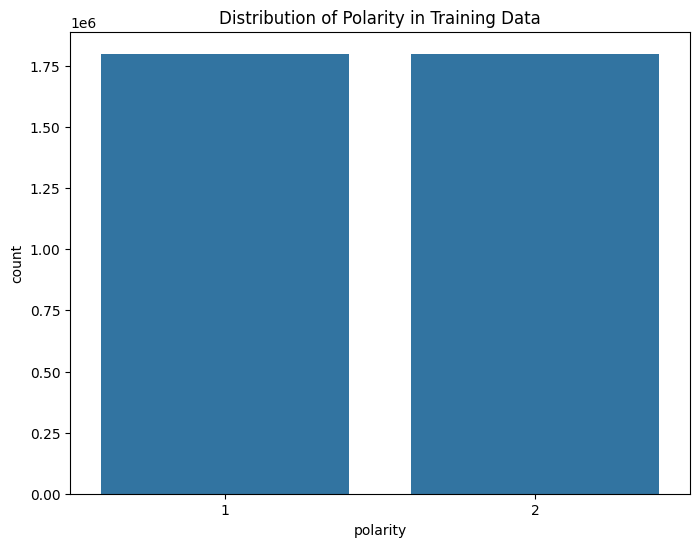

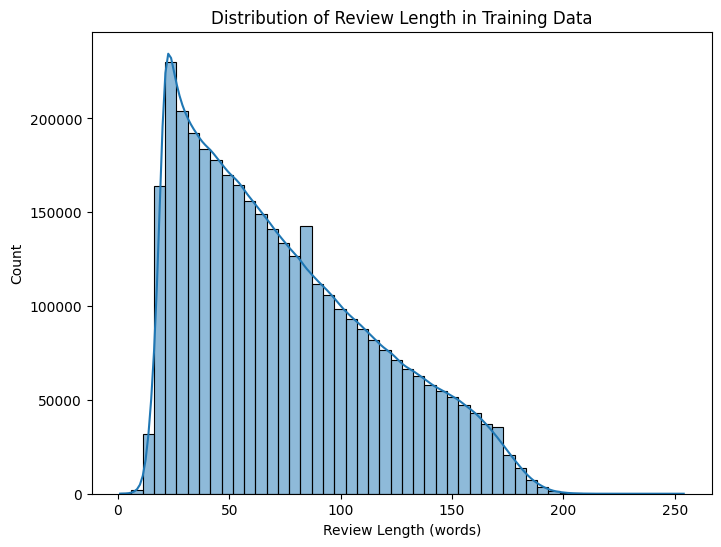

(50002, 3)


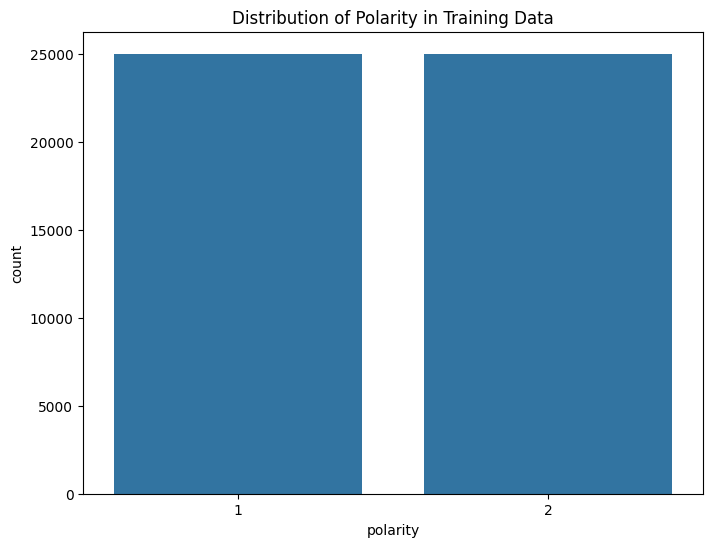

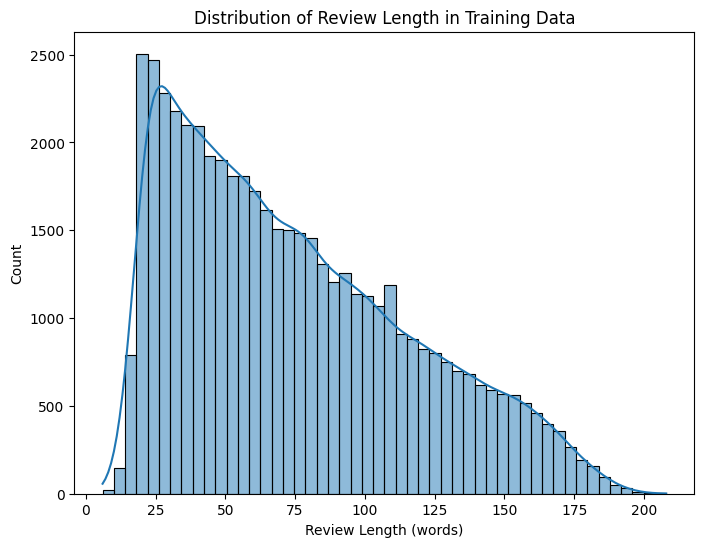

156
(10001, 3)
True


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


--2025-06-08 04:38:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-08 04:38:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-08 04:38:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [4]:
import zipfile
import re
import tarfile
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import contractions
nltk.download('punkt')
nltk.download('punkt_tab')
with zipfile.ZipFile('amazon_review_polarity_csv.tgz.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_tgz')
tgz_path = os.path.join('extracted_tgz', 'amazon_review_polarity_csv.tgz')
with tarfile.open(tgz_path, 'r:gz') as tar:
    tar.extractall(path='extracted_csv')
train_df = pd.read_csv('extracted_csv/amazon_review_polarity_csv/train.csv',header=None,names=["polarity", "title", "text"])
test_df = pd.read_csv('extracted_csv/amazon_review_polarity_csv/test.csv',header=None,names=["polarity", "title", "text"])
print(train_df.shape)
print(test_df.shape)
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())
train_unique = train_df.drop_duplicates(subset=["title", "text"]).shape[0]
test_unique = test_df.drop_duplicates(subset=["title", "text"]).shape[0]
print(f"Number of unique entries in training data: {train_unique}")
print(f"Number of unique entries in testing data: {test_unique}")
plt.figure(figsize=(8, 6))
sns.countplot(x='polarity', data=train_df)
plt.title('Distribution of Polarity in Training Data')
plt.show()
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))  # or just len(x) if you want chars
plt.figure(figsize=(8, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Review Length in Training Data')
plt.xlabel('Review Length (words)')
plt.show()
train_df.drop(columns=['text_length'], inplace=True)
train_df['review_length'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['length_bin'] = pd.qcut(train_df['review_length'], q=10, duplicates='drop')
train_df['strata'] = train_df['polarity'].astype(str) + '_' + train_df['length_bin'].astype(str)
desired_sample_size = 50000
grouped = train_df.groupby('strata', group_keys=False)
stratum_sizes = grouped.size()
stratum_proportions = stratum_sizes / stratum_sizes.sum()
stratum_sample_sizes = (stratum_proportions * desired_sample_size).round().astype(int)
samples = []
for name, group in grouped:
    n = stratum_sample_sizes.get(name, 0)
    sampled = group.sample(n=min(len(group), n), random_state=42)
    samples.append(sampled)
train_df = pd.concat(samples).reset_index(drop=True)
train_df.drop(columns=['review_length', 'length_bin', 'strata'], inplace=True)
print(train_df.shape)
plt.figure(figsize=(8, 6))
sns.countplot(x='polarity', data=train_df)
plt.title('Distribution of Polarity in Training Data')
plt.show()
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Review Length in Training Data')
plt.xlabel('Review Length (words)')
plt.show()
padding_length = int(np.percentile(train_df['text_length'], 95))
print(padding_length)
train_df.drop(columns=['text_length'], inplace=True)
test_df['review_length'] = test_df['text'].apply(lambda x: len(x.split()))
test_df['length_bin'] = pd.qcut(test_df['review_length'], q=10, duplicates='drop')
test_df['strata'] = test_df['polarity'].astype(str) + '_' + test_df['length_bin'].astype(str)
desired_test_sample_size = 10000
grouped_test = test_df.groupby('strata', group_keys=False)
stratum_sizes_test = grouped_test.size()
stratum_proportions_test = stratum_sizes_test / stratum_sizes_test.sum()
stratum_sample_sizes_test = (stratum_proportions_test * desired_test_sample_size).round().astype(int)
samples_test = []
for name, group in grouped_test:
    n = stratum_sample_sizes_test.get(name, 0)
    sampled = group.sample(n=min(len(group), n), random_state=42)
    samples_test.append(sampled)
test_df = pd.concat(samples_test).reset_index(drop=True)
test_df.drop(columns=['review_length', 'length_bin', 'strata'], inplace=True)
print(test_df.shape)
import nltk
import seaborn as sns
nltk.download('wordnet')
nltk.download('punkt')
import re
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import matplotlib.pyplot as plt
import contractions
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
train_df['text'] = train_df['title'].fillna('') + ' ' + train_df['text'].fillna('')
test_df['text'] = test_df['title'].fillna('') + ' ' + test_df['text'].fillna('')
train_df.drop(columns=['title'], inplace=True)
test_df.drop(columns=['title'], inplace=True)
train_df['polarity'] = train_df['polarity'].map({1: 0, 2: 1})
test_df['polarity'] = test_df['polarity'].map({1: 0, 2: 1})
def preprocess_text(text):
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    return tokens
def expand_contractions(text):
    return contractions.fix(text)
train_df['text'] = train_df['text'].apply(expand_contractions)
test_df['text'] = test_df['text'].apply(expand_contractions)
train_df['tokens'] = train_df['text'].apply(preprocess_text)
test_df['tokens'] = test_df['text'].apply(preprocess_text)
def build_vocab(tokenized_texts, max_vocab_size=10000):
    counter = Counter([token for text in tokenized_texts for token in text])
    vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.most_common(max_vocab_size))}
    vocab['<PAD>'] = 0
    vocab['<OOV>'] = len(vocab)
    return vocab
vocab = build_vocab(train_df['tokens'])
def encode_texts(tokenized_texts, vocab):
    return [[vocab.get(token, vocab['<OOV>']) for token in text] for text in tokenized_texts]
train_encoded = encode_texts(train_df['tokens'], vocab)
test_encoded = encode_texts(test_df['tokens'], vocab)
def pad_sequences(sequences, max_length, padding_value=0):
    padded_sequences = np.full((len(sequences), max_length), fill_value=padding_value, dtype=int)
    for i, seq in enumerate(sequences):
        padded_sequences[i, :min(len(seq), max_length)] = seq[:max_length]
    return padded_sequences
max_length = 150
X_train_padded = pad_sequences(train_encoded, max_length)
X_test_padded = pad_sequences(test_encoded, max_length)
y_train = train_df['polarity'].values
y_test = test_df['polarity'].values
X_train, X_val, y_train, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
batch_size = 128
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
def load_filtered_glove(glove_path, vocab, embedding_dim=300):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in vocab:
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word] = vector
    return embeddings
def build_embedding_matrix(vocab, glove_embeddings, embedding_dim=300):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in vocab.items():
        vector = glove_embeddings.get(word)
        if vector is not None:
            embedding_matrix[idx] = vector
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    return embedding_matrix
glove_path = 'glove.6B.300d.txt'
embedding_dim = 300
glove_embeddings = load_filtered_glove(glove_path, vocab, embedding_dim)
embedding_matrix = build_embedding_matrix(vocab, glove_embeddings, embedding_dim)
embedding_matrix_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix_tensor, freeze=False,padding_idx=0)
class LSTM_Model(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_layer_size, number_of_classes,embedding_weights):
        super(LSTM_Model, self).__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_weights, freeze=False,padding_idx=0)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, batch_first=True, bidirectional=True)
        self.classification_layer = nn.Linear(hidden_layer_size * 2, number_of_classes)
        self.dropout_layer = nn.Dropout(0.5)
    def forward(self, input_sequences):
        embedded_input = self.embedding_layer(input_sequences)
        lstm_output, (hidden_state, cell_state) = self.lstm_layer(embedded_input)
        final_hidden = torch.cat((hidden_state[0], hidden_state[1]), dim=1)
        dropped_out_hidden_state = self.dropout_layer(final_hidden)
        output_classification = self.classification_layer(dropped_out_hidden_state)
        return output_classification
embedding_size = 300
hidden_layer_size = 128
number_of_classes = 2
vocabulary_size = len(vocab)
maximum_sequence_length = 150
model = LSTM_Model( vocabulary_size = vocabulary_size,embedding_size = embedding_size,hidden_layer_size = hidden_layer_size,number_of_classes = number_of_classes,embedding_weights=embedding_matrix_tensor,).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer_function = optim.Adam(model.parameters(), lr=0.001)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_preds = 0
        total_preds = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        train_accuracy = 100 * correct_preds / total_preds
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        model.eval()
        val_loss = 0
        val_correct_preds = 0
        val_total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)
        val_accuracy = 100 * val_correct_preds / val_total_preds
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_lstm_model.pth')
    return train_losses, val_losses, train_accuracies, val_accuracies
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, loss_function, optimizer_function, num_epochs= 10)
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs[0].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions
test_data = TensorDataset(torch.tensor(X_test_padded, dtype=torch.long).to(device),torch.tensor(y_test, dtype=torch.long).to(device))
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
test_predictions = predict(model, test_loader)
accuracy = accuracy_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)
y_test_array = np.array(y_test)
false_positives_idx = [i for i in range(len(y_test_array)) if y_test_array[i] == 0 and test_predictions[i] == 1]
false_negatives_idx = [i for i in range(len(y_test_array)) if y_test_array[i] == 1 and test_predictions[i] == 0]
all_misclassified_idx = false_positives_idx + false_negatives_idx
misclassified_lengths = [len(test_df['text'][i].split()) for i in all_misclassified_idx]
average_misclassified_length = np.mean(misclassified_lengths)
print(f"Number of False Positives: {len(false_positives_idx)}")
print(f"Number of False Negatives: {len(false_negatives_idx)}")
print(f"Average length of misclassified reviews: {average_misclassified_length:.2f} words")
def print_misclassified_examples(indices, category, n=5):
    print(f"\n--- {category} Examples ---")
    for i in indices[:n]:
        print(f"Text: {test_df['text'][i]}")
        print(f"True Label: {y_test_array[i]}, Predicted Label: {test_predictions[i]}")
        print("---")
print_misclassified_examples(false_positives_idx, "False Positives")
print_misclassified_examples(false_negatives_idx, "False Negatives")


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
class BiRNN_Model(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_layer_size, number_of_classes, embedding_weights):
        super(BiRNN_Model, self).__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_weights, freeze=False, padding_idx=0)
        self.rnn_layer = nn.RNN(embedding_size, hidden_layer_size, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(0.5)
        self.classification_layer = nn.Linear(hidden_layer_size * 2, number_of_classes)

    def forward(self, input_sequences):
        embedded_input = self.embedding_layer(input_sequences)
        rnn_output, hidden_state = self.rnn_layer(embedded_input)
        final_hidden = torch.cat((hidden_state[0], hidden_state[1]), dim=1)
        dropped_out_hidden_state = self.dropout_layer(final_hidden)
        output_classification = self.classification_layer(dropped_out_hidden_state)
        return output_classification
model1 = BiRNN_Model( vocabulary_size=vocabulary_size,embedding_size=embedding_size,hidden_layer_size=hidden_layer_size,number_of_classes=number_of_classes,embedding_weights=embedding_matrix_tensor).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer_function = optim.Adam(model1.parameters(), lr=0.001)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_preds = 0
        total_preds = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        train_accuracy = 100 * correct_preds / total_preds
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        model.eval()
        val_loss = 0
        val_correct_preds = 0
        val_total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)
        val_accuracy = 100 * val_correct_preds / val_total_preds
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_lstm_model.pth')
    return train_losses, val_losses, train_accuracies, val_accuracies
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model1, train_loader, val_loader, loss_function, optimizer_function, num_epochs= 10)
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs[0].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions
test_data = TensorDataset(torch.tensor(X_test_padded, dtype=torch.long).to(device),torch.tensor(y_test, dtype=torch.long).to(device))
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
test_predictions1 = predict(model1, test_loader)
accuracy = accuracy_score(y_test, test_predictions1)
f1 = f1_score(y_test, test_predictions1)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
conf_matrix = confusion_matrix(y_test, test_predictions1)
print("Confusion Matrix:")
print(conf_matrix)
y_test_array = np.array(y_test)
false_positives_idx = [i for i in range(len(y_test_array)) if y_test_array[i] == 0 and test_predictions1[i] == 1]
false_negatives_idx = [i for i in range(len(y_test_array)) if y_test_array[i] == 1 and test_predictions1[i] == 0]
all_misclassified_idx = false_positives_idx + false_negatives_idx
misclassified_lengths = [len(test_df['text'][i].split()) for i in all_misclassified_idx]
average_misclassified_length = np.mean(misclassified_lengths)
print(f"Number of False Positives: {len(false_positives_idx)}")
print(f"Number of False Negatives: {len(false_negatives_idx)}")
print(f"Average length of misclassified reviews: {average_misclassified_length:.2f} words")
def print_misclassified_examples(indices, category, n=5):
    print(f"\n--- {category} Examples ---")
    for i in indices[:n]:
        print(f"Text: {test_df['text'][i]}")
        print(f"True Label: {y_test_array[i]}, Predicted Label: {test_predictions1[i]}")
        print("---")
print_misclassified_examples(false_positives_idx, "False Positives")
print_misclassified_examples(false_negatives_idx, "False Negatives")

True
Epoch 1/10, Train Loss: 0.4111, Train Accuracy: 81.37%, Val Loss: 0.3825, Val Accuracy: 84.04%
Epoch 2/10, Train Loss: 0.3471, Train Accuracy: 85.38%, Val Loss: 0.3588, Val Accuracy: 84.72%
Epoch 3/10, Train Loss: 0.3032, Train Accuracy: 87.80%, Val Loss: 0.3576, Val Accuracy: 85.93%
Epoch 4/10, Train Loss: 0.2656, Train Accuracy: 89.71%, Val Loss: 0.3623, Val Accuracy: 84.91%
Epoch 5/10, Train Loss: 0.2525, Train Accuracy: 90.25%, Val Loss: 0.3661, Val Accuracy: 85.28%
Epoch 6/10, Train Loss: 0.2272, Train Accuracy: 91.51%, Val Loss: 0.3901, Val Accuracy: 85.59%
Epoch 7/10, Train Loss: 0.2031, Train Accuracy: 92.59%, Val Loss: 0.3925, Val Accuracy: 84.81%
Epoch 8/10, Train Loss: 0.2012, Train Accuracy: 92.39%, Val Loss: 0.4081, Val Accuracy: 85.23%
Epoch 9/10, Train Loss: 0.1883, Train Accuracy: 93.10%, Val Loss: 0.4399, Val Accuracy: 85.18%
Epoch 10/10, Train Loss: 0.1614, Train Accuracy: 94.16%, Val Loss: 0.4987, Val Accuracy: 83.15%
Accuracy: 0.8329
F1-Score: 0.8156
Confusion 

<ipython-input-6-93cb1c375caa>:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rnn_correct_lengths, label="BiRNN Correct", shade=True)
<ipython-input-6-93cb1c375caa>:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(lstm_correct_lengths, label="BiLSTM Correct", shade=True)


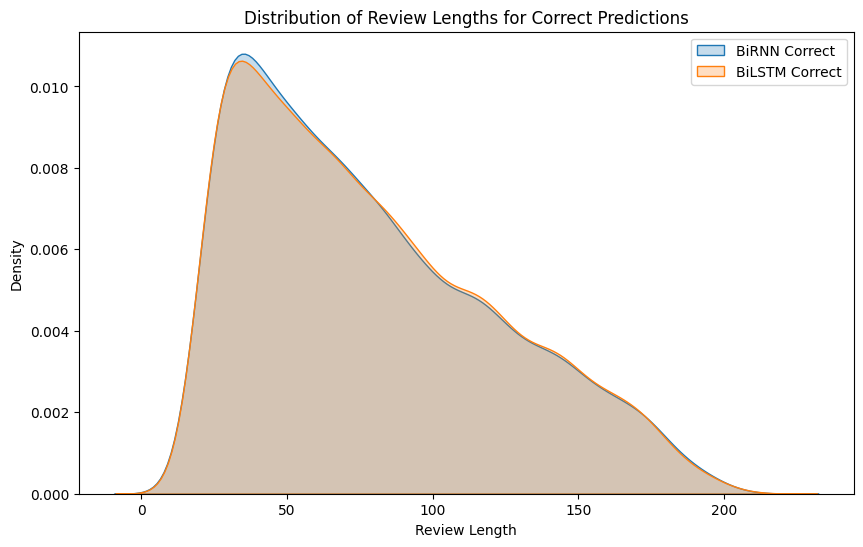

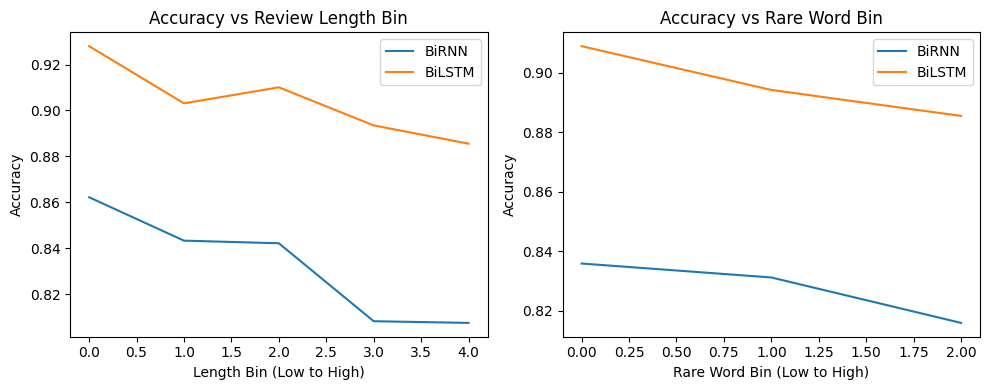

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
y_test_array = np.array(y_test)
train_tokens = [word for review in train_df['text'] for word in review.split()]
word_freq = Counter(train_tokens)
rare_words = set([word for word, freq in word_freq.items() if freq == 1])
def count_rare_words(text, rare_words):
    return sum(1 for word in text.split() if word in rare_words)
test_df['rare_word_count'] = test_df['text'].apply(lambda x: count_rare_words(x, rare_words))
test_df['review_length'] = test_df['text'].apply(lambda x: len(x.split()))
correct_rnn_idx = [i for i, (pred, true) in enumerate(zip(test_predictions1, y_test_array)) if pred == true]
correct_lstm_idx = [i for i, (pred, true) in enumerate(zip(test_predictions, y_test_array)) if pred == true]
rnn_correct_lengths = test_df.iloc[correct_rnn_idx]['review_length']
lstm_correct_lengths = test_df.iloc[correct_lstm_idx]['review_length']
plt.figure(figsize=(10, 6))
sns.kdeplot(rnn_correct_lengths, label="BiRNN Correct", shade=True)
sns.kdeplot(lstm_correct_lengths, label="BiLSTM Correct", shade=True)
plt.xlabel("Review Length")
plt.ylabel("Density")
plt.title("Distribution of Review Lengths for Correct Predictions")
plt.legend()
plt.show()
test_df['length_bin'] = pd.qcut(test_df['review_length'], q=5, labels=False, duplicates='drop')
test_df['rare_bin'] = pd.qcut(test_df['rare_word_count'], q=5, labels=False, duplicates='drop')
test_df['rnn_correct'] = [int(pred == true) for pred, true in zip(test_predictions1, y_test_array)]
test_df['lstm_correct'] = [int(pred == true) for pred, true in zip(test_predictions, y_test_array)]
rnn_length_perf = test_df.groupby('length_bin')['rnn_correct'].mean()
lstm_length_perf = test_df.groupby('length_bin')['lstm_correct'].mean()
rnn_rare_perf = test_df.groupby('rare_bin')['rnn_correct'].mean()
lstm_rare_perf = test_df.groupby('rare_bin')['lstm_correct'].mean()
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(rnn_length_perf, label="BiRNN")
plt.plot(lstm_length_perf, label="BiLSTM")
plt.title("Accuracy vs Review Length Bin")
plt.xlabel("Length Bin (Low to High)")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(rnn_rare_perf, label="BiRNN")
plt.plot(lstm_rare_perf, label="BiLSTM")
plt.title("Accuracy vs Rare Word Bin")
plt.xlabel("Rare Word Bin (Low to High)")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()
